In [1]:
import os
import sys

# to import functions from `patching_utils.py` and `plotly_utils.py`,
# we need to add the repository directory to the system path.
current_dir = os.path.dirname(os.getcwd())
print(current_dir)
if current_dir not in sys.path:
    sys.path.append(current_dir)

/home/qinyuan/function-induction


In [2]:
import torch as t

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import colorsys

plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.sans-serif'] = 'DejaVu Serif' 

In [4]:
# Color and marker definitions
color_map = {
    'consolidate': '#7030a0',
    'function_induction': '#0070c0', 
    'prev_token': '#4da72e', 
    'empty_set': '#909090',
}
def brighten(color, factor=1.6):
    """Brighten a hex color by increasing its lightness."""
    rgb = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(*rgb)
    l = min(1.0, l * factor)  # boost lightness
    new_rgb = colorsys.hls_to_rgb(h, l, s)
    return new_rgb  # returns RGB tuple
new_color_map = {k: brighten(v) for k, v in color_map.items()}

### Gemma-2 (8B)

#### Upper Row

In [5]:
result_post_resid_41 = t.load("results/gemma_2_9b/resid_post_41.pt")
result_h39_7_v = t.load("results/gemma_2_9b/ind_h39_7_v.pt")

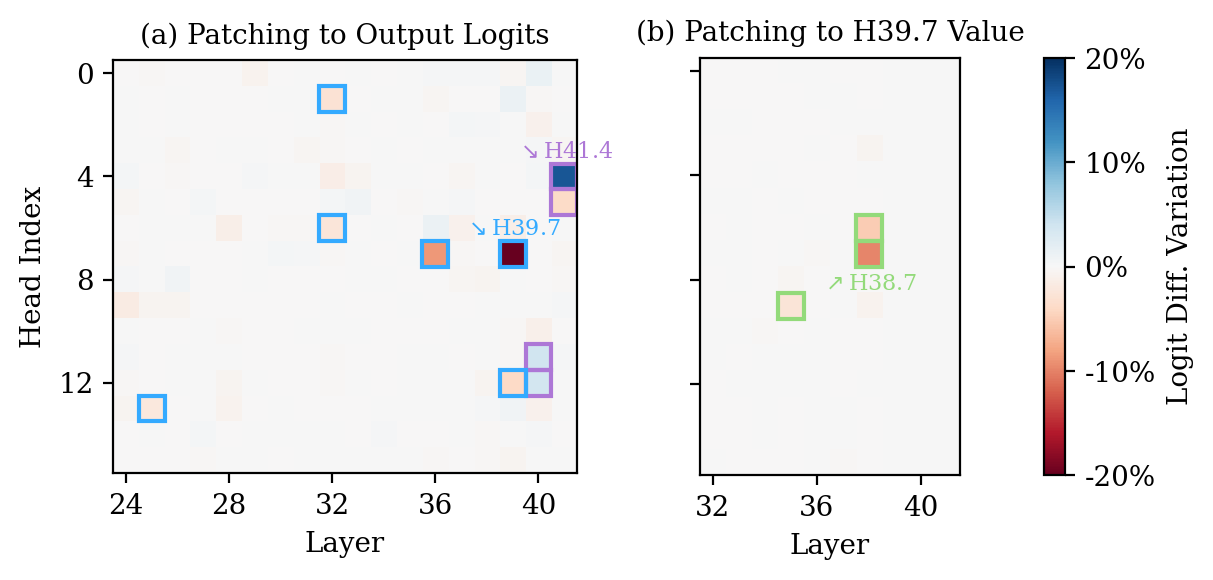

In [6]:
cons_heads = [(41, 4), (41, 5), (40, 11), (40, 12)]
ind1_heads = [(39,7), (39,12), (36,7), (32, 1), (32,6), (25, 13)]
prev_heads = [(38,6), (38,7), (35,9)] # identified by patching to H39.7 v

offset = 24 # show results after layer 24
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.2, 3), dpi=200, sharey=True)

temp_result = result_post_resid_41[offset:].t()
im = ax1.imshow(temp_result, cmap='RdBu', vmin=-0.2, vmax=0.2, origin='upper')


# Highlight selected positions with magenta squares
for layer_idx, head_idx in cons_heads:
    rect = plt.Rectangle((layer_idx - 0.5 - offset, head_idx - 0.5), 1, 1,
                         edgecolor=new_color_map["consolidate"], facecolor='none', linewidth=1.5)
    ax1.add_patch(rect)
for layer_idx, head_idx in ind1_heads:
    rect = plt.Rectangle((layer_idx - 0.5 - offset, head_idx - 0.5), 1, 1,
                         edgecolor=new_color_map["function_induction"], facecolor='none', linewidth=1.5)
    ax1.add_patch(rect)

ax1.text(
    41-offset, 4-1+0.05,
    r"$\searrow$H41.4",
    ha='center', va='center',
    color=new_color_map["consolidate"], 
    fontsize=8,
)


ax1.text(
    39-offset, 7-1+0.05,
    r"$\searrow$H39.7",
    ha='center', va='center',
    color=new_color_map["function_induction"], 
    fontsize=8,
)

# Labels
ax1.set_xlabel("Layer")
ax1.set_ylabel("Head Index")
ax1.set_yticks([i for i in range(0, 16, 4)])
ax1.set_xticks([i for i in range(0, 42-offset, 4)])
ax1.set_xticklabels([i+offset for i in range(0, 42-offset, 4)])
ax1.set_title("(a) Patching to Output Logits", fontsize=10)

offset = 32
temp_result = result_h39_7_v[offset:].t()
im = ax2.imshow(temp_result, cmap='RdBu', vmin=-0.2, vmax=0.2, origin='upper')

for layer_idx, head_idx in prev_heads:
    rect = plt.Rectangle((layer_idx - 0.5 - offset, head_idx - 0.5), 1, 1,
                         edgecolor=new_color_map["prev_token"], facecolor='none', linewidth=1.5)
    ax2.add_patch(rect)


ax2.text(
    38-offset, 7+1+0.15,
    r"$\nearrow$H38.7",
    ha='center', va='center',
    color=new_color_map["prev_token"], 
    fontsize=8,
)

# Add colorbar
cbar = fig.colorbar(im, ax=ax2, pad=0.18)
cbar.set_label("Logit Diff. Variation")
cbar.set_ticks([-0.2, -0.1, 0, 0.1, 0.2])
cbar.set_ticklabels(['-20%', '-10%', '0%', '10%', '20%'])

# Labels
ax2.set_xlabel("Layer")
# ax.set_ylabel("Head Index")
ax2.set_yticks([i for i in range(0, 16, 4)])
ax2.set_xticks([i for i in range(0, 42-offset, 4)])
ax2.set_xticklabels([i+offset for i in range(0, 42-offset, 4)])
ax2.set_title("(b) Patching to H39.7 Value", fontsize=10)


plt.tight_layout()
plt.savefig("figures/gemma_2_circuit_1.pdf", dpi=300, bbox_inches='tight', pad_inches=0.0)
plt.show()

#### Lower Row
Extract attention pattern from the first four examples

In [7]:
device="cuda:3"

In [8]:
from transformer_lens import HookedTransformer, patching, ActivationCache, utils
from transformer_lens.hook_points import HookPoint

from patching_utils import prepare_data_for_fwd
from data_utils import process_dataset, read_jsonl

/home/qinyuan/miniconda3/envs/fi4/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
model_name = "google/gemma-2-9b"
model = HookedTransformer.from_pretrained(model_name, device=device) # fp32
model.set_ungroup_grouped_query_attention(True)

setting, nmax, offset, n_icl_examples = "setting1", 9, 1, 4
filename = f"../data/addition/{setting}/addition_nmax{nmax}_offset{offset}.jsonl"
data = read_jsonl(filename)
processed_data = process_dataset(data, n_icl_examples=n_icl_examples, offset=offset)

Loading checkpoint shards: 100%|██████████| 8/8 [00:00<00:00, 158.20it/s]


Loaded pretrained model google/gemma-2-9b into HookedTransformer


In [10]:
a_batch = processed_data[:4]
normal_input, contrast_input, normal_answer, contrast_answer, \
    normal_cache, contrast_cache, normal_logits, contrast_logits = prepare_data_for_fwd(model, a_batch)

In [11]:
t1 = contrast_cache["pattern", 41][:, 4].mean(0).cpu()
t2 = contrast_cache["pattern", 39][:, 7].mean(0).cpu()
t3 = contrast_cache["pattern", 38][:, 7].mean(0).cpu()

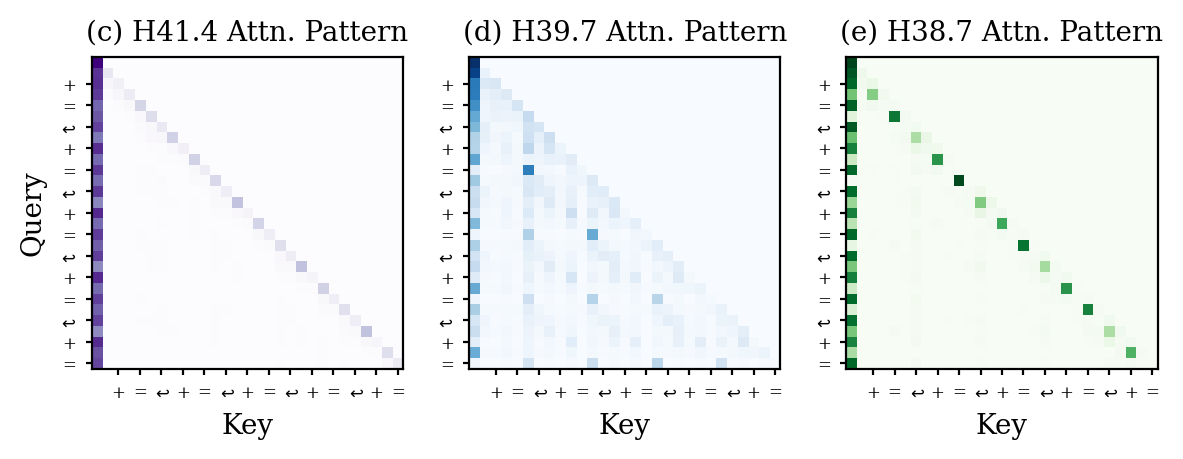

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 3), dpi=200)

im = ax1.imshow(t1, cmap='Purples', vmin=0, vmax=1, origin='upper')
ax1.set_title("(c) H41.4 Attn. Pattern", fontsize=10)

xs = list(range(2,29,2))
ys = ["+", "=", r"$\hookleftarrow$"] * 4 + [ "+", "="]
ax1.set_yticks(xs)
ax1.set_yticklabels(ys, fontsize=6)
ax1.set_xticks(xs)
ax1.set_xticklabels(ys, fontsize=6)
ax1.tick_params(axis='both', length=2)  # default is ~4–6
ax1.set_ylabel("Query")
ax1.set_xlabel("Key")

im = ax2.imshow(t2, cmap='Blues', vmin=0, vmax=1, origin='upper')
ax2.set_title("(d) H39.7 Attn. Pattern", fontsize=10)
ax2.set_yticks(xs)
ax2.set_yticklabels(ys, fontsize=6)
ax2.set_xticks(xs)
ax2.set_xticklabels(ys, fontsize=6)
ax2.tick_params(axis='both', length=2)  # default is ~4–6
ax2.set_xlabel("Key")

im = ax3.imshow(t3, cmap='Greens', vmin=0, vmax=1, origin='upper')
ax3.set_title("(e) H38.7 Attn. Pattern", fontsize=10)
ax3.set_yticks(xs)
ax3.set_yticklabels(ys, fontsize=6)
ax3.set_xticks(xs)
ax3.set_xticklabels(ys, fontsize=6)
ax3.tick_params(axis='both', length=2)  # default is ~4–6
ax3.set_xlabel("Key")

plt.tight_layout()
plt.savefig("figures/gemma_2_circuit_2.pdf", dpi=300, bbox_inches='tight', pad_inches=0.0)
plt.show()
